In [39]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [40]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [41]:
len(words)

32033

In [42]:
# build vocab
chars = list(sorted(set("".join(words))))
stoi = {s: i for i, s in enumerate(["."] + chars)}
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

In [43]:
block_size = 3


def build_dataset(_words):
    X, Y = [], []
    for w in _words[:]:
        # print(w)
        context = [0] * block_size

        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [79]:
# mlp revisited
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)

# reduce the initial weight & bias to avoid saturation of the activation function thereby getting a better
# distribution through tanh.
# Initialize weights small to keep pre-activation values in tanh's linear region
# (avoid saturation at -1/+1 where gradients vanish since the derivative of tanh is 0 at these extremes)
W1 = (
    torch.randn((n_embed * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embed * block_size) ** 0.5)
)  # kaiming init # * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01

# Initialize weights small to prevent initial logits from being too extreme,
# which would cause saturated softmax (all probability on one class) and slow learning
# Small weights -> small initial logits -> softmax not saturated → better gradients
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01

# Initialize bias to 0. At the start, we want uniform probability over all characters.
# Non-zero bias would artificially favor certain characters before any learning.
b2 = torch.randn(vocab_size, generator=g) * 0.0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [80]:
# optimisation
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = embcat @ W1 + b1

    # this is batch-norm. this allows the hidden layers to have a guassian distribution with
    # some gain & bias
    # batch normalisation has a regularising effect on the nn as w & b of a nn now get coupled in batched.
    # it is weird & second order unintended effect.
    h_preact = (
        bngain
        * (h_preact - h_preact.mean(0, keepdim=True))
        / h_preact.std(0, keepdim=True)
        + bnbias
    )
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


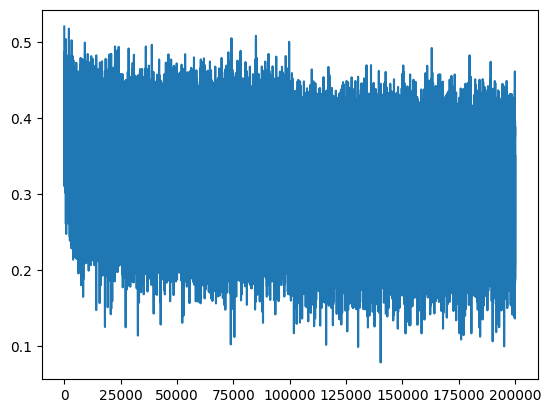

In [77]:
plt.plot(lossi);

In [82]:
# batch norm happens on batches of data, but inference doesn't happen in batches;
# hence, calculate the mean & std on the entire training set

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = embcat @ W1 + b1

    bnmean = h_preact.mean(0, keepdim=True)
    bnstd = h_preact.std(0, keepdim=True)

In [83]:
@torch.no_grad  # disable gradient tracking
def split_loss(split):
    x, y = {"train": (Xtr, Ytr), "val": (Xdev, Ydev), "test": (Xte, Yte)}[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = embcat @ W1 + b1
    # we don't want mean & std to vary for the splits. training vals are what matter.
    # h_preact = bngain * (h_preact - h_preact.mean(0, keepdim=True)) / h_preact.std(0, keepdim=True) + bnbias
    h_preact = bngain * (h_preact - bnmean) / bnstd + bnbias
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.0668270587921143
val 2.1049270629882812


In [61]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        h_preact = embcat @ W1 + b1
        h = torch.tanh(h_preact)
        logits = h @ W2 + b2

        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print("".join(itos[i] for i in out))

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
waythoniearyn.
kai.
euliyuan.
eddeli.


In [38]:
# initial loss of 27 is super extreme. considering, for an untrained nn, any letter is equally likely, we know that the probabalities
# assigned by cross entropy have to be more uniform & hence smoother!

# expected is ~3.2 while init is ~27 something. which is pretty random
-torch.tensor(1 / 27.0).log()

tensor(3.2958)